# Event logging analysis
>*Event logging* (EL) is used to track a variety of performance and usage metrics to help on the decision making process

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data loading and preprocessing

In [110]:
df = pd.read_csv('events_log.csv')

In [111]:
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257940 entries, 0 to 257939
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   uuid             257940 non-null  object 
 1   timestamp        257939 non-null  float64
 2   session_id       257939 non-null  object 
 3   group            257939 non-null  object 
 4   action           257939 non-null  object 
 5   checkin          144149 non-null  float64
 6   page_id          257939 non-null  object 
 7   n_results        87999 non-null   float64
 8   result_position  148377 non-null  float64
dtypes: float64(4), object(5)
memory usage: 17.7+ MB


Drop empty rows

In [6]:
df.dropna(subset=['timestamp'], inplace=True)

Parse date

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')

## Look at the data

In [8]:
delta = df['timestamp'].max() - df['timestamp'].min()
print(f'Earliest event: {df["timestamp"].min()}')
print(f'Latest event: {df["timestamp"].max()}')
print(f'Difference: {delta}')

Earliest event: 2016-03-01 00:00:02
Latest event: 2016-03-08 20:24:29
Difference: 7 days 20:24:27


In [9]:
sessions = len(df['session_id'].unique())
print(f'Unique sessions: {sessions}')

Unique sessions: 56875


## 1. Daily overall clickthrough rate

>*Clickthrough rate*: the proportion of search sessions where the user clicked on one of the results displayed.

Getting page visits, that are clicks on the results, and searches, that returned results > 0.

In [62]:
page_visits = df[(df['action'] == 'visitPage') & (df['result_position'].notnull())]
searches = df[(df['action'] == 'searchResultPage') & (df['n_results'] > 0)]

Calculating number of each event grouped by day.

In [58]:
click_number = page_visits.groupby(df['timestamp'].dt.date)['uuid'].count()
search_number = searches.groupby(df['timestamp'].dt.date)['uuid'].count()
clck_rate = (click_number/search_number).to_frame('clickthrough_rate')

### Clicktrough rate by date

In [60]:
clck_rate

,clickthrough_rate
timestamp,
2016-03-01,0.293111
2016-03-02,0.298354
2016-03-03,0.306717
2016-03-04,0.321856
2016-03-05,0.306040
2016-03-06,0.306237
2016-03-07,0.298593
2016-03-08,0.312779


### Average daily clickthrough rate

In [63]:
avg_clck_rate = clck_rate.mean()[0]
print(f'Clickthrough rate: {avg_clck_rate:.3f}')

Clickthrough rate: 0.305


### Clickthrough rate by group

In [76]:
click_number_group = page_visits.groupby([df['timestamp'].dt.date, 'group'])['uuid'].count()
search_number_group = searches.groupby([df['timestamp'].dt.date, 'group'])['uuid'].count()
clck_rate_group = (click_number_group/search_number_group).to_frame('clickthrough_rate')

In [77]:
clck_rate_group

clickthrough_rate
timestamp  group                   
2016-03-01 a               0.393022
           b               0.089342
2016-03-02 a               0.395251
           b               0.096238
2016-03-03 a               0.403412
           b               0.101700
2016-03-04 a               0.424420
           b               0.131536
2016-03-05 a               0.412575
           b               0.126018
2016-03-06 a               0.411326
           b               0.124039
2016-03-07 a               0.394349
           b               0.127706
2016-03-08 a               0.423691
           b               0.115999

### Average daily clickthrough rate by group

In [45]:
def annotate(figure, dformat):
    for p in figure.patches:
             figure.annotate(dformat % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', fontsize=11, color='white', xytext=(0, -20),
                          textcoords='offset points')    

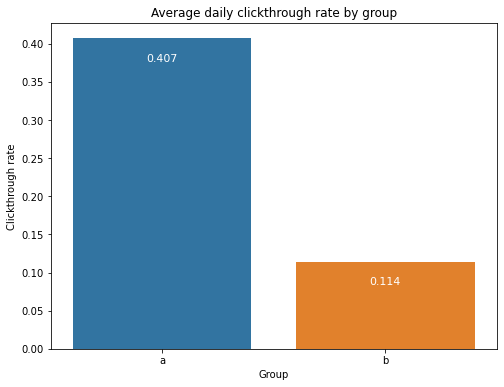

In [66]:
avg_clck_grouped = clck_rate_group.mean(level='group')
plt.figure(figsize=(8,6))
fig = sns.barplot(x=avg_clck_grouped.index, y='clickthrough_rate', data=avg_clck_grouped)
plt.title('Average daily clickthrough rate by group')
plt.xlabel('Group')
plt.ylabel('Clickthrough rate')
annotate(fig, '%.3f')  
plt.show()

In [67]:
a_rate = avg_clck_grouped['clickthrough_rate']['a']
b_rate = avg_clck_grouped['clickthrough_rate']['b']

In [68]:
print(f'GROUP A average daily clickthrough rate:  {a_rate:.3f}')
print(f'GROUP B average daily clickthrough rate:  {b_rate:.3f}')
print(f'Difference:  {abs(b_rate-a_rate):.3f}')

GROUP A average daily clickthrough rate:  0.407
GROUP B average daily clickthrough rate:  0.114
Difference:  0.293


Daily clickthrough rate **varies a lot** between the groups. It's **higher for the group A by 0.293**

## 2. Daily overall zero results rate
*Zero results rate*: the proportion of searches that yielded 0 results.

In [69]:
empty_searches = df[(df['action'] == 'searchResultPage') & (df['n_results'] == 0)]
empty_searches_number = empty_searches.groupby(df['timestamp'].dt.date)['uuid'].count()
all_searches = df[df['action'] == 'searchResultPage']
all_searches_number = all_searches.groupby(df['timestamp'].dt.date)['uuid'].count()
zero_rate = (empty_searches_number/all_searches_number).to_frame('zero_rate')
zero_rate

,zero_rate
timestamp,
2016-03-01,0.186918
2016-03-02,0.192652
2016-03-03,0.181877
2016-03-04,0.184218
2016-03-05,0.186371
2016-03-06,0.176334
2016-03-07,0.178179
2016-03-08,0.189837


In [75]:
zero_rate_group.to_csv('zero.csv')
clck_rate_group.to_csv('click.csv')

### Average daily zero results rate

In [78]:
avg_zero_rate = zero_rate.mean()[0]
print(f'Zero results rate: {avg_zero_rate:.3f}')

Zero results rate: 0.185


### Daily zero results rate by group

In [70]:
empty_searches_group = empty_searches.groupby([df['timestamp'].dt.date, 'group'])['uuid'].count()
all_searches_group = all_searches.groupby([df['timestamp'].dt.date, 'group'])['uuid'].count()
zero_rate_group = (empty_searches_group/all_searches_group).to_frame('zero_rate')
zero_rate_group

zero_rate
timestamp  group           
2016-03-01 a       0.190997
           b       0.178470
2016-03-02 a       0.197830
           b       0.181632
2016-03-03 a       0.185779
           b       0.173480
2016-03-04 a       0.191200
           b       0.170938
2016-03-05 a       0.181596
           b       0.194314
2016-03-06 a       0.174651
           b       0.179237
2016-03-07 a       0.183039
           b       0.169360
2016-03-08 a       0.197021
           b       0.176770

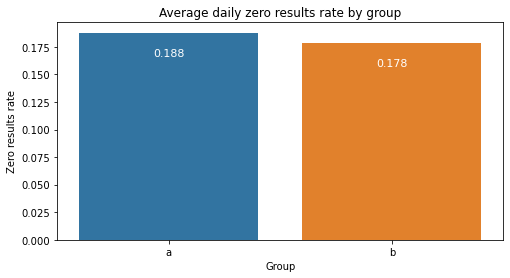

In [79]:
avg_zero_grouped = zero_rate_group.mean(level='group')
plt.figure(figsize=(8,4))
fig = sns.barplot(x=avg_zero_grouped.index, y='zero_rate', data=avg_zero_grouped)
plt.title('Average daily zero results rate by group')
plt.xlabel('Group')
plt.ylabel('Zero results rate')
annotate(fig, '%.3f')  
plt.show()

In [72]:
a_zrate = avg_zero_grouped['zero_rate']['a']
b_zrate = avg_zero_grouped['zero_rate']['b']

In [73]:
print(f'GROUP A average daily zero results rate:  {a_zrate:.3f}')
print(f'GROUP B average daily zero results rate:  {b_zrate:.3f}')
print(f'Difference:  {abs(b_zrate-a_zrate):.3f}')

GROUP A average daily zero results rate:  0.188
GROUP B average daily zero results rate:  0.178
Difference:  0.010


Daily zero results rate **doesn't vary a lot** between the groups. It's only **higher for the group A by 0.01**

## 3. Session length

In [25]:
session_start = df.groupby('session_id')['timestamp'].min()
session_end = df.groupby('session_id')['timestamp'].max()
session_length = (session_end - session_start).to_frame('session_length')
session_length['session_length'] = session_length['session_length'].dt.seconds

In [26]:
df = df.join(session_length, on='session_id')

In [27]:
df['session_length'].describe()

count    257939.000000
mean        471.538321
std        2041.726451
min           0.000000
25%          65.000000
50%         298.000000
75%         447.000000
max       80293.000000
Name: session_length, dtype: float64

Lets look at relationship between **session length** and **group**.

In [33]:
df.groupby('group')['session_length'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
a,192565.0,554.277891,2200.245977,0.0,114.0,354.0,516.0,80293.0
b,65374.0,227.821473,1452.035590,0.0,0.0,77.0,371.0,70798.0


In [89]:
zero_session = (df[df['session_length'] == 0].groupby('group')['uuid'].count() / 
                df.groupby('group')['uuid'].count()).to_frame('zero_session')

Let's plot **average session length** by group and **zero length session rate**, which shows *the proportion of sessions that contain only one event*.

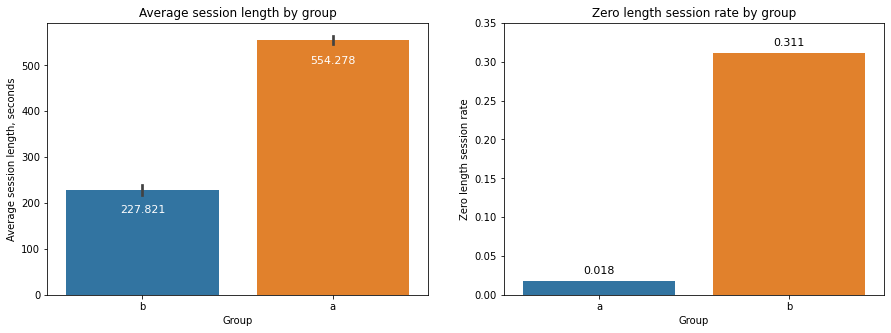

In [106]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
fig = sns.barplot(data=df, x='group', y='session_length', estimator=np.mean)
plt.title('Average session length by group')
plt.xlabel('Group')
plt.ylabel('Average session length, seconds')
annotate(fig, '%.3f')  

plt.subplot(1, 2, 2)
fig2 = sns.barplot(x=zero_session.index, y=zero_session.zero_session)
plt.title('Zero length session rate by group')
plt.xlabel('Group')
plt.ylabel('Zero length session rate')
plt.ylim(0, 0.35)
for p in fig2.patches:
             fig2.annotate('%.3f' % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                          textcoords='offset points')    

plt.show()

**Group A** has **larger average session length** and vastly **lower zero length session rate**.

## 4. Dashboard

## [Tableau dashboard](https://public.tableau.com/shared/RB2SJCQD9?:display_count=y&:origin=viz_share_link)

<img src='tableau.png' width='600'>

## 5. Summary

With the help of given data we figured out that group A has higher daily clickthrough rate, higher average session length and lower number of zero length sessions, than group B. Daily zero results are similar for both groups. From all this we can make a conclusion that group A is more engaged and it's not affected by zero results.